In [25]:
import itertools
import numpy as np
import pandas as pd
import pickle as pkl
import requests
import seaborn as sns
import os

from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Any, Dict, List, Tuple, Union
from xgboost import XGBClassifier

from microservice import IUMModel
from utility import (
    load_data,
    get_buckets_indices,
    get_prediction_based_on_probabilities,
    get_most_optimal_threshold,
    get_s_p,
    get_t,
    get_xgb_logreg_f1_scores,
    is_xgb_better,
    BUCKETS_CNT,
    T_ALPHA,
)

ImportError: cannot import name 'get_prediction_based_on_probabilities' from 'utility' (/home/bartlomiejkrawczyk/IUM/utility.py)

In [4]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f"features/{FEATURE_VERSION}/feature.csv"

FEATURES = [
    'number_of_advertisements',
    'number_of_tracks',
    'number_of_skips',
    'number_of_likes',
    'number_of_liked_tracks_listened',
    'number_of_tracks_in_favourite_genre',
    'total_number_of_favourite_genres_listened',
    'average_popularity_in_favourite_genres',
    'total_tracks_duration_ms',
    'number_of_different_artists',
    'average_release_date',
    'average_duration_ms',
    'explicit_tracks_ratio',
    'average_popularity',
    'average_acousticness',
    'average_danceability',
    'average_energy',
    'average_instrumentalness',
    'average_liveness',
    'average_loudness',
    'average_speechiness',
    'average_tempo',
    'average_valence',
    'average_track_name_length',
    'average_daily_cost'
]

TARGETS = [
    "premium_user_numerical",
    "will_buy_premium_next_month_numerical"
]

TARGET_AND_FEATURES = TARGETS + FEATURES

In [5]:
data_frame = pd.read_csv(FEATURE_PATH)

In [6]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


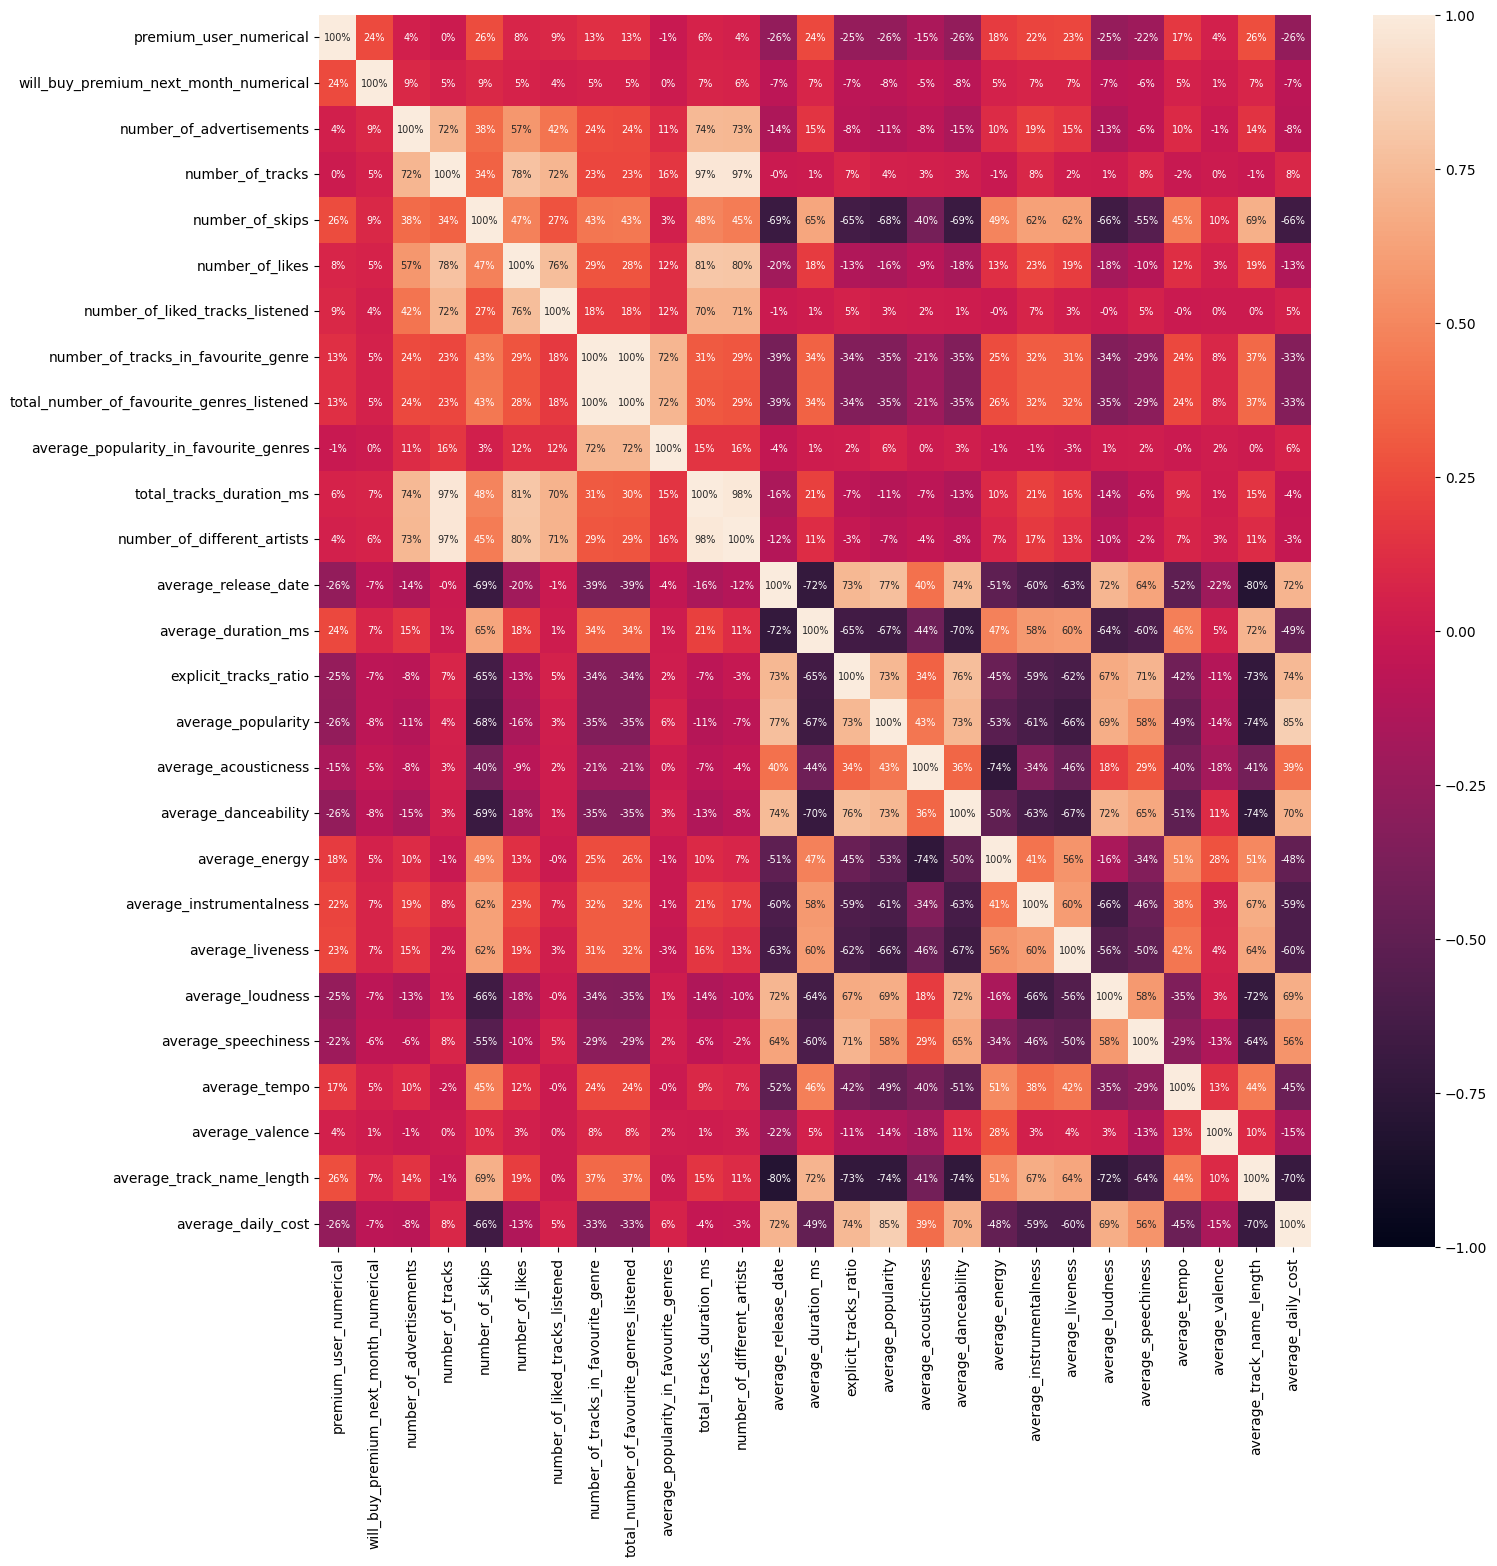

In [7]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plt.figure(figsize=(16, 16))

sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,  # type: ignore
    yticklabels=correlation_matrix.columns,  # type: ignore
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0%",
    vmin=-1,
    vmax=1,
)

plt.show()

In [8]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

In [9]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

TODO: pipeline dobieramy na podstawie samych danych testowych


In [10]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

In [11]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,-1.106969,-1.460751,0.144720,-1.369484,-1.285806,-0.079364,0.207361,0.050866,-0.910861,-1.456670,...,-0.897928,-0.045755,-0.582859,1.376483,-1.516811,-1.262413,0.883219,-1.187277,5.793993,0.079036
1,-0.110104,-0.777185,0.144720,-0.532571,-0.700979,-0.643869,-0.612159,-1.010899,-0.668980,-0.619715,...,-1.025966,0.394645,0.056067,1.717991,-1.433667,-1.093168,-0.586762,1.252747,0.649835,-1.170679
2,-0.359320,-0.679533,0.486716,-1.090513,-1.090864,0.296973,0.207361,-0.205888,-0.311719,-0.500151,...,-1.103880,2.358611,2.169324,-0.381179,-0.511329,-0.937221,1.895053,1.379783,0.657382,-0.753120
3,-1.356185,-0.874837,-0.026278,-0.811542,-0.895921,0.485142,0.371265,0.026735,-0.617293,-0.739280,...,-0.593754,2.124100,1.141931,0.224089,-0.533879,-1.145840,-0.756789,-0.183719,0.370230,-0.950314
4,-0.359320,-1.167794,-0.539272,-0.811542,-1.090864,-0.643869,-0.612159,-1.010899,-1.271211,-1.217540,...,1.413296,0.380679,-1.020787,-0.071114,1.179603,1.113158,-0.651901,0.720222,-0.610420,3.117353


In [12]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
61455,1,0
23693,1,0
146451,1,0
33621,0,0
121230,0,0


In [ ]:
ArrayLike = Any


class WrappedXGBC(XGBClassifier):
    def __init__(self, **params: Any):
        super().__init__(**params)

    def fit(self, X: ArrayLike, y: ArrayLike):
        super(WrappedXGBC, self).fit(X, y)
        probabilities = self.predict_proba(X)
        self.thr = get_most_optimal_threshold(y, probabilities)
        return self

    def predict(self, X: ArrayLike) -> np.ndarray:
        y_pred_proba = super(WrappedXGBC, self).predict_proba(X)
        return get_preds_thr(y_pred_proba, self.thr)

In [13]:
DUMMY = 'dummy'
LOGISTIC_REG = 'logistic_regression'
XGB = 'xgb_classifier'
RANDOM = 'randomized_search'

MODEL_TYPES = [DUMMY, LOGISTIC_REG, XGB, RANDOM]


def construct_dummy(X_train: pd.DataFrame, y_train: pd.DataFrame) -> DummyClassifier:
    return DummyClassifier().fit(X_train, y_train)


def construct_logistic_reggression(X_train: pd.DataFrame, y_train: pd.DataFrame) -> LogisticRegression:
    return LogisticRegression().fit(X_train, y_train)


def construct_xgb_classifier(X_train: pd.DataFrame, y_train: pd.DataFrame) -> XGBClassifier:
    return XGBClassifier().fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(X_train: pd.DataFrame, y_train: pd.DataFrame) -> XGBClassifier:
    CANDIDATES = 1
    model = XGBClassifier()
    # TODO: update with own parameters

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            "max_depth": np.arange(3, 30, 1),
            "eta": uniform(0, 0.1),
            "gamma": uniform(0, 1),
            "n_estimators": np.arange(10, 100, 1),
        },
        n_iter=CANDIDATES,
        scoring="f1",
        n_jobs=-1,
        verbose=3,
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    return estimator.best_estimator_  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    RANDOM: construct_xgb_classifier_with_randomized_search
}
Model = Union[
    DummyClassifier,
    LogisticRegression,
    XGBClassifier
]
# TODO: might keep best parameters / threshold here too
MODELS: Dict[str, Dict[str, Model]] = {}

for type in MODEL_TYPES:
    MODELS[type] = {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END eta=0.006435407501642099, gamma=0.25743106391255755, max_depth=11, n_estimators=39;, score=0.081 total time= 2.4min
[CV 2/5] END eta=0.006435407501642099, gamma=0.25743106391255755, max_depth=11, n_estimators=39;, score=0.098 total time= 2.4min
[CV 1/5] END eta=0.006435407501642099, gamma=0.25743106391255755, max_depth=11, n_estimators=39;, score=0.086 total time= 2.4min
[CV 3/5] END eta=0.006435407501642099, gamma=0.25743106391255755, max_depth=11, n_estimators=39;, score=0.094 total time= 2.4min
[CV 5/5] END eta=0.006435407501642099, gamma=0.25743106391255755, max_depth=11, n_estimators=39;, score=0.091 total time= 2.4min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END eta=0.08085608381734792, gamma=0.415440988344673, max_depth=5, n_estimators=83;, score=0.009 total time= 2.0min
[CV 4/5] END eta=0.08085608381734792, gamma=0.415440988344673, max_depth=5, n_estimators=83;, score=0.004 total 

DUMMY
F1 score for premium_user_numerical: 0.0
F1 score for will_buy_premium_next_month_numerical: 0.0


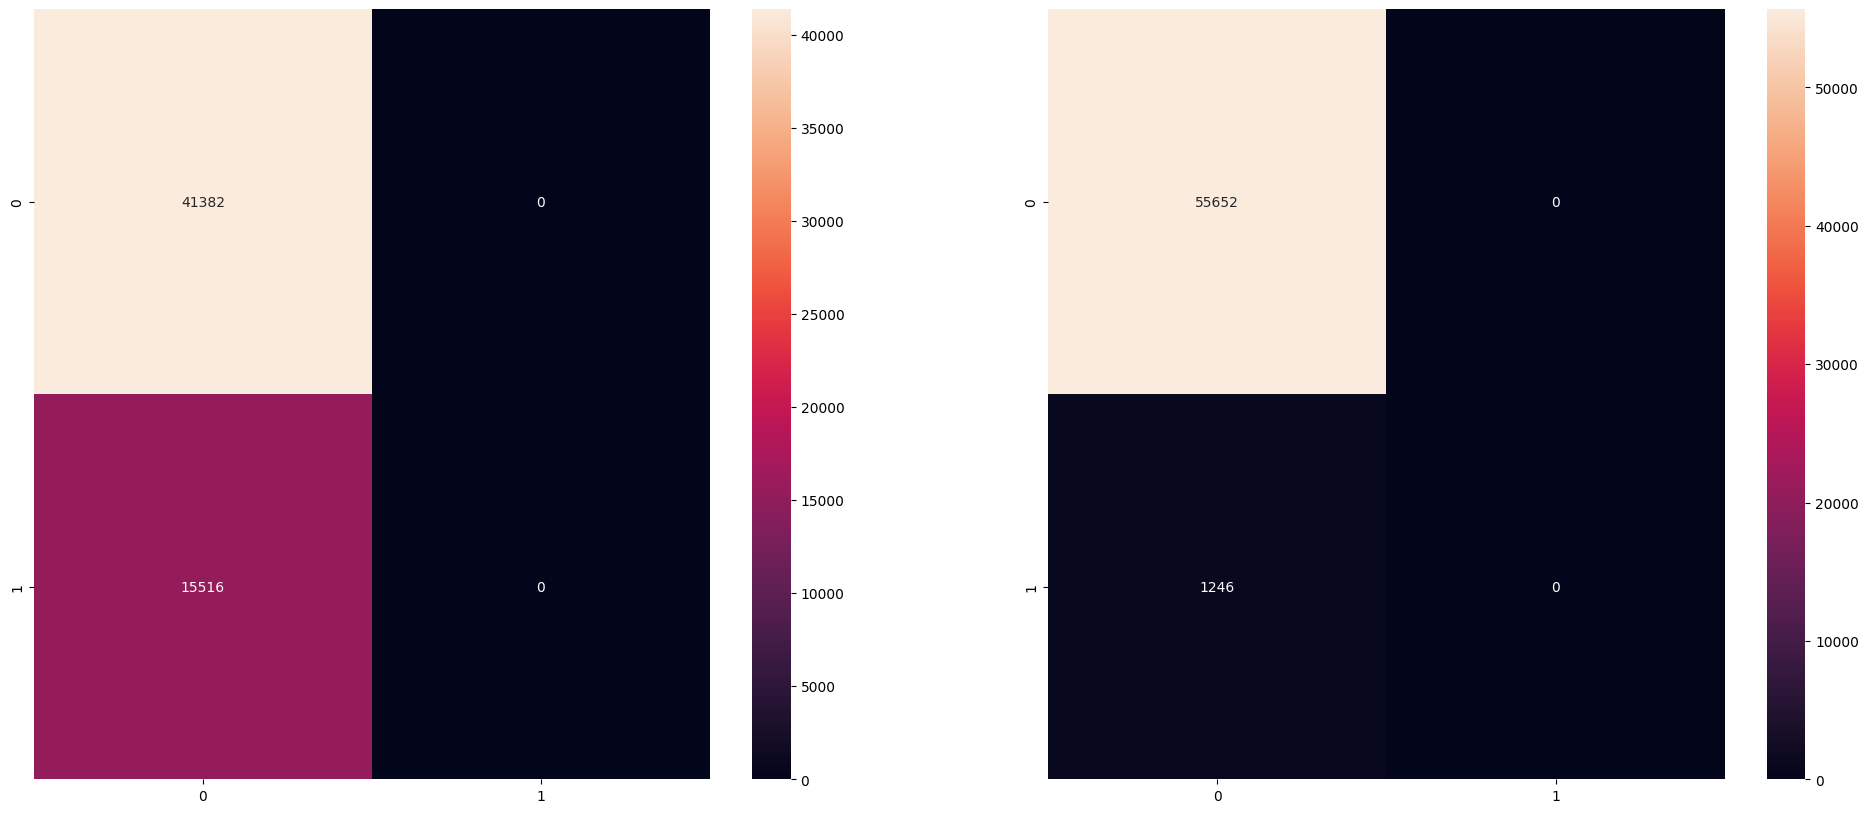

LOGISTIC_REGRESSION
F1 score for premium_user_numerical: 0.0957483983692487
F1 score for will_buy_premium_next_month_numerical: 0.0


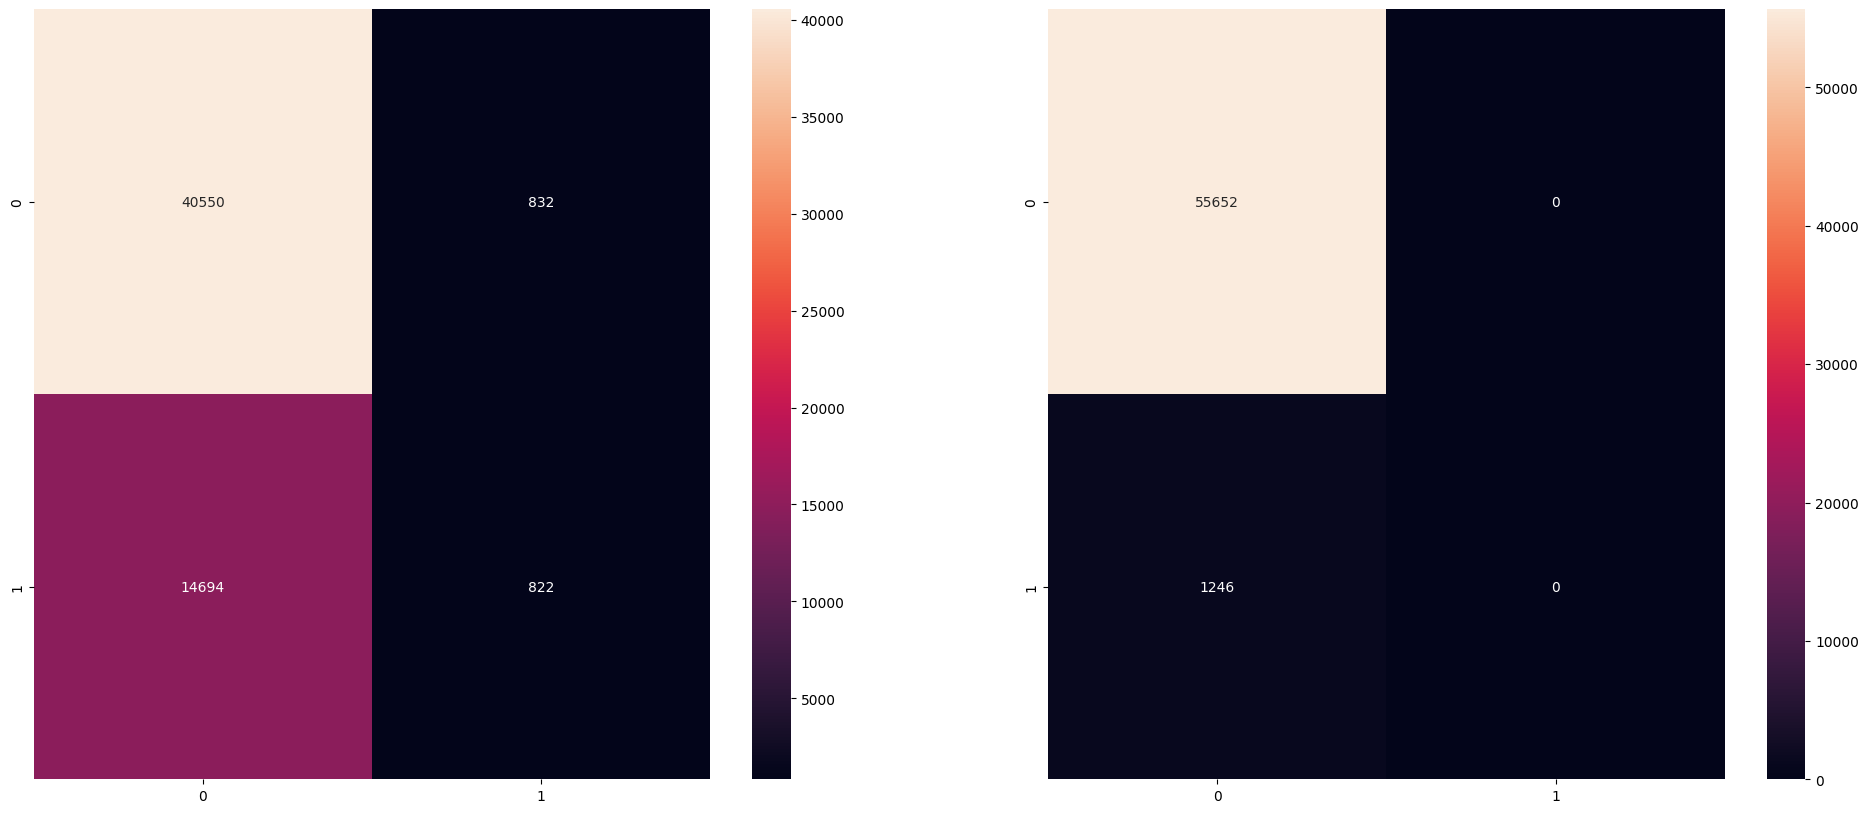

XGB_CLASSIFIER
F1 score for premium_user_numerical: 0.19792562610675438
F1 score for will_buy_premium_next_month_numerical: 0.02304147465437788


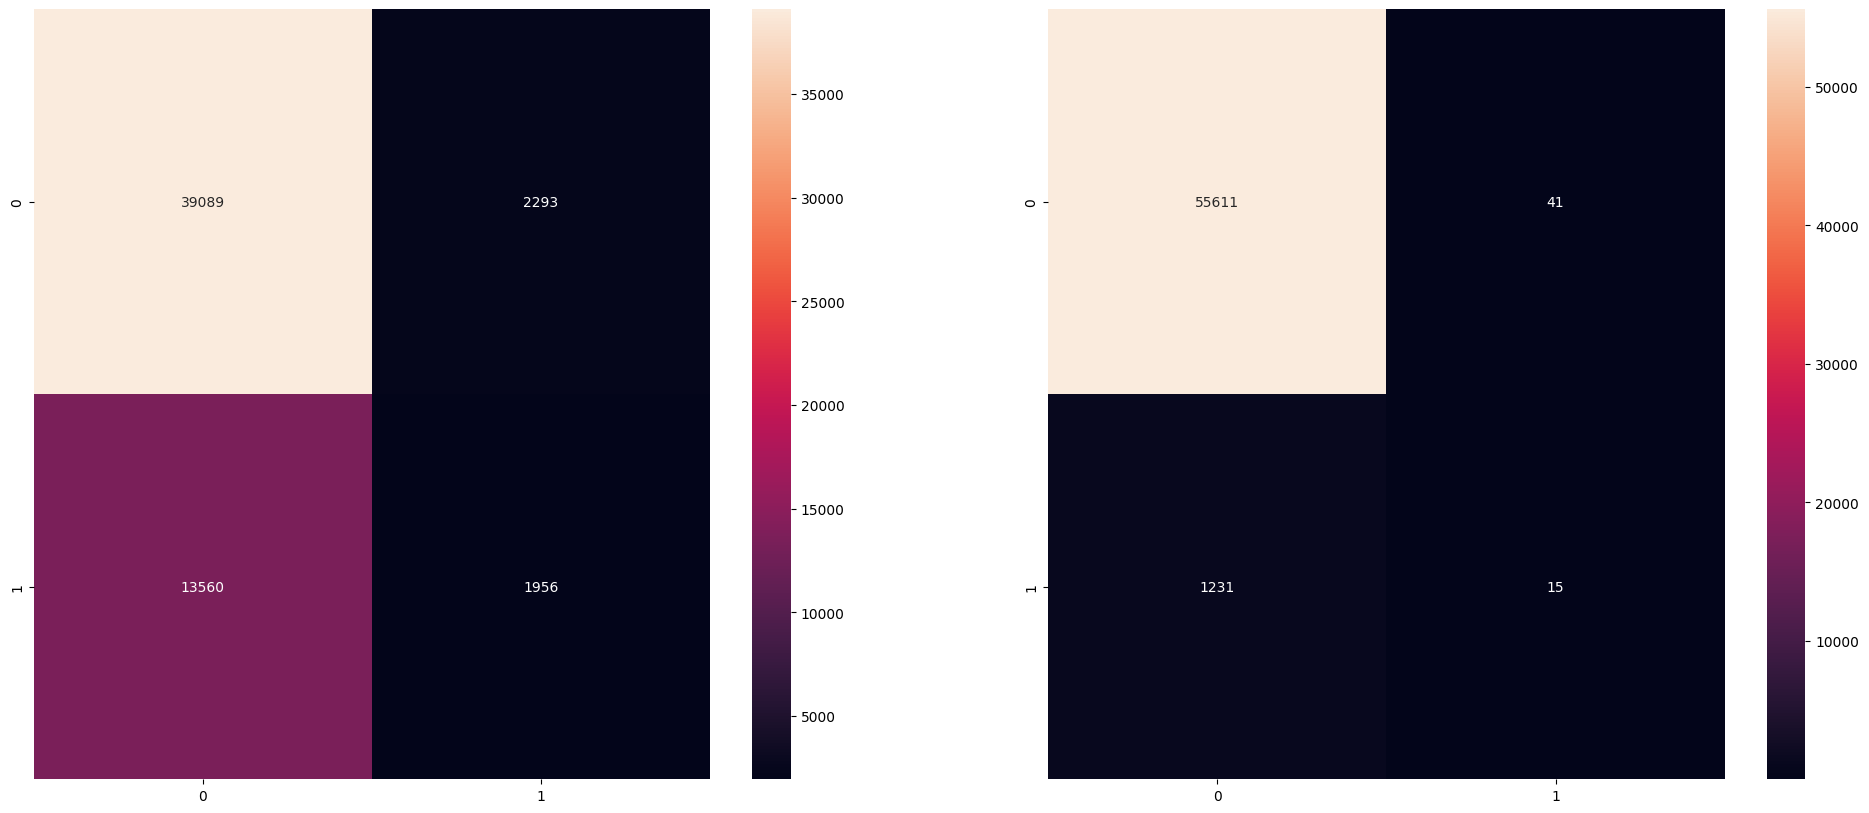

RANDOMIZED_SEARCH
F1 score for premium_user_numerical: 0.09470591623941471
F1 score for will_buy_premium_next_month_numerical: 0.0016025641025641023


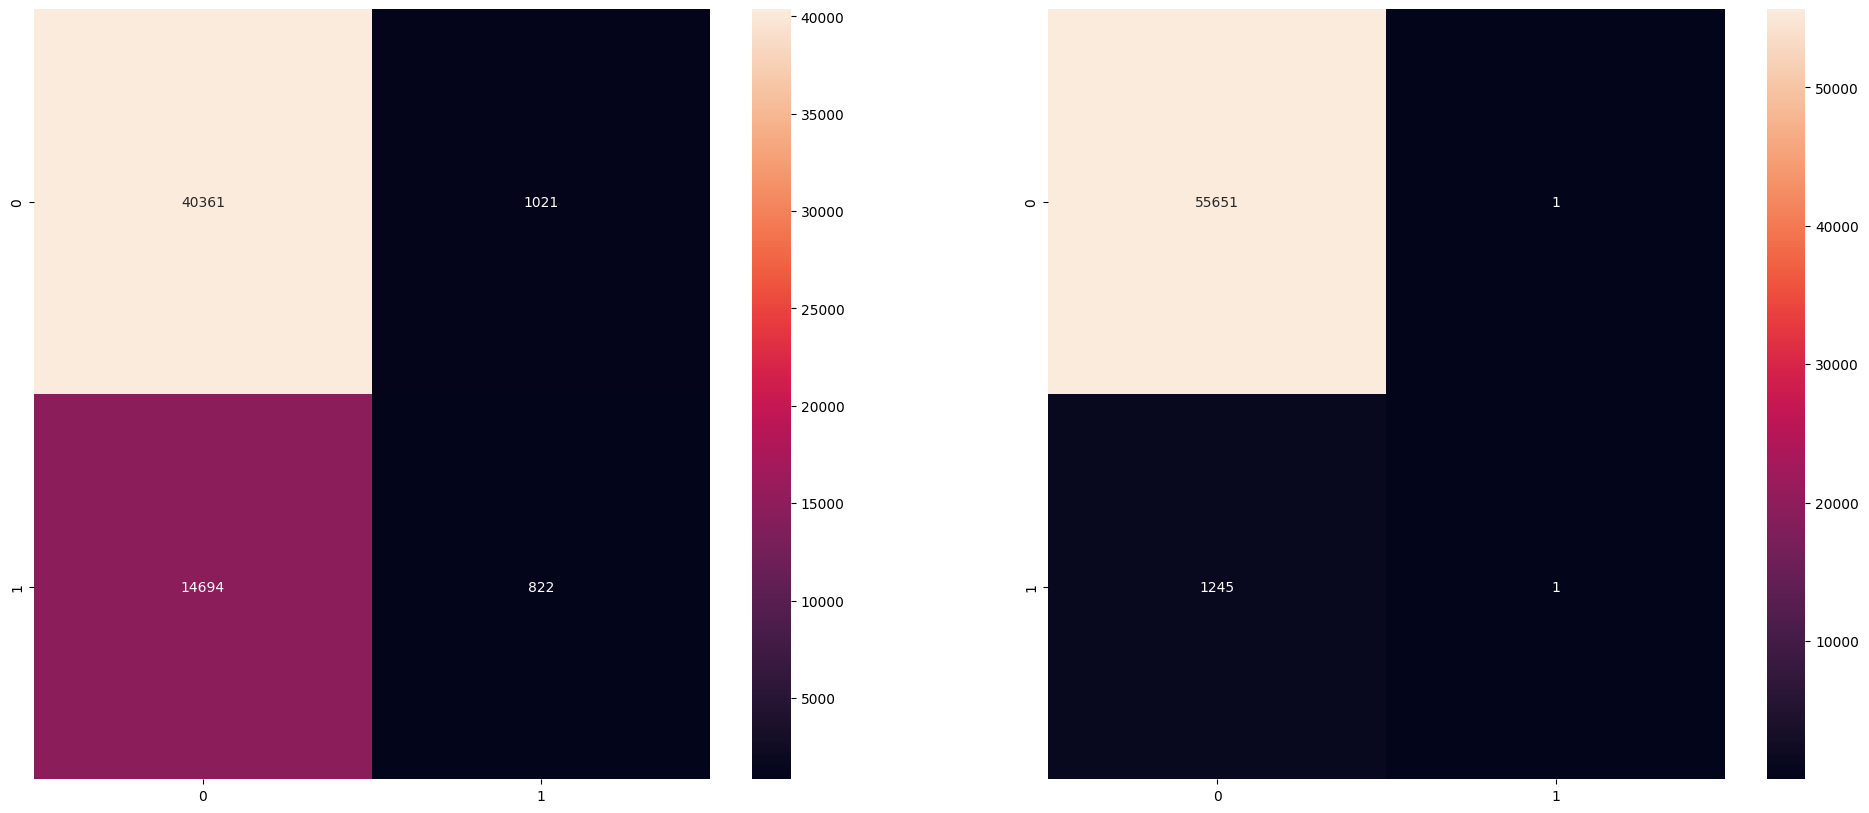

In [21]:
for type in MODEL_TYPES:
    print(type.upper())
    _, axs = plt.subplots(1, 2, figsize=(24, 10))  # type: ignore
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        y_predicted = model.predict(X_test)
        matrix_y_true = Y_test[target]
        f1_score_value = f1_score(matrix_y_true, y_predicted)
        print(f"F1 score for {target}: {f1_score_value}")
        matrix = confusion_matrix(matrix_y_true, y_predicted)
        sns.heatmap(
            matrix,
            annot=True,
            fmt='g',
            xticklabels=["0", "1"],  # type: ignore
            yticklabels=["0", "1"],  # type: ignore
            ax=axs[i]  # type: ignore
        )
    plt.show()

TODO: start from here

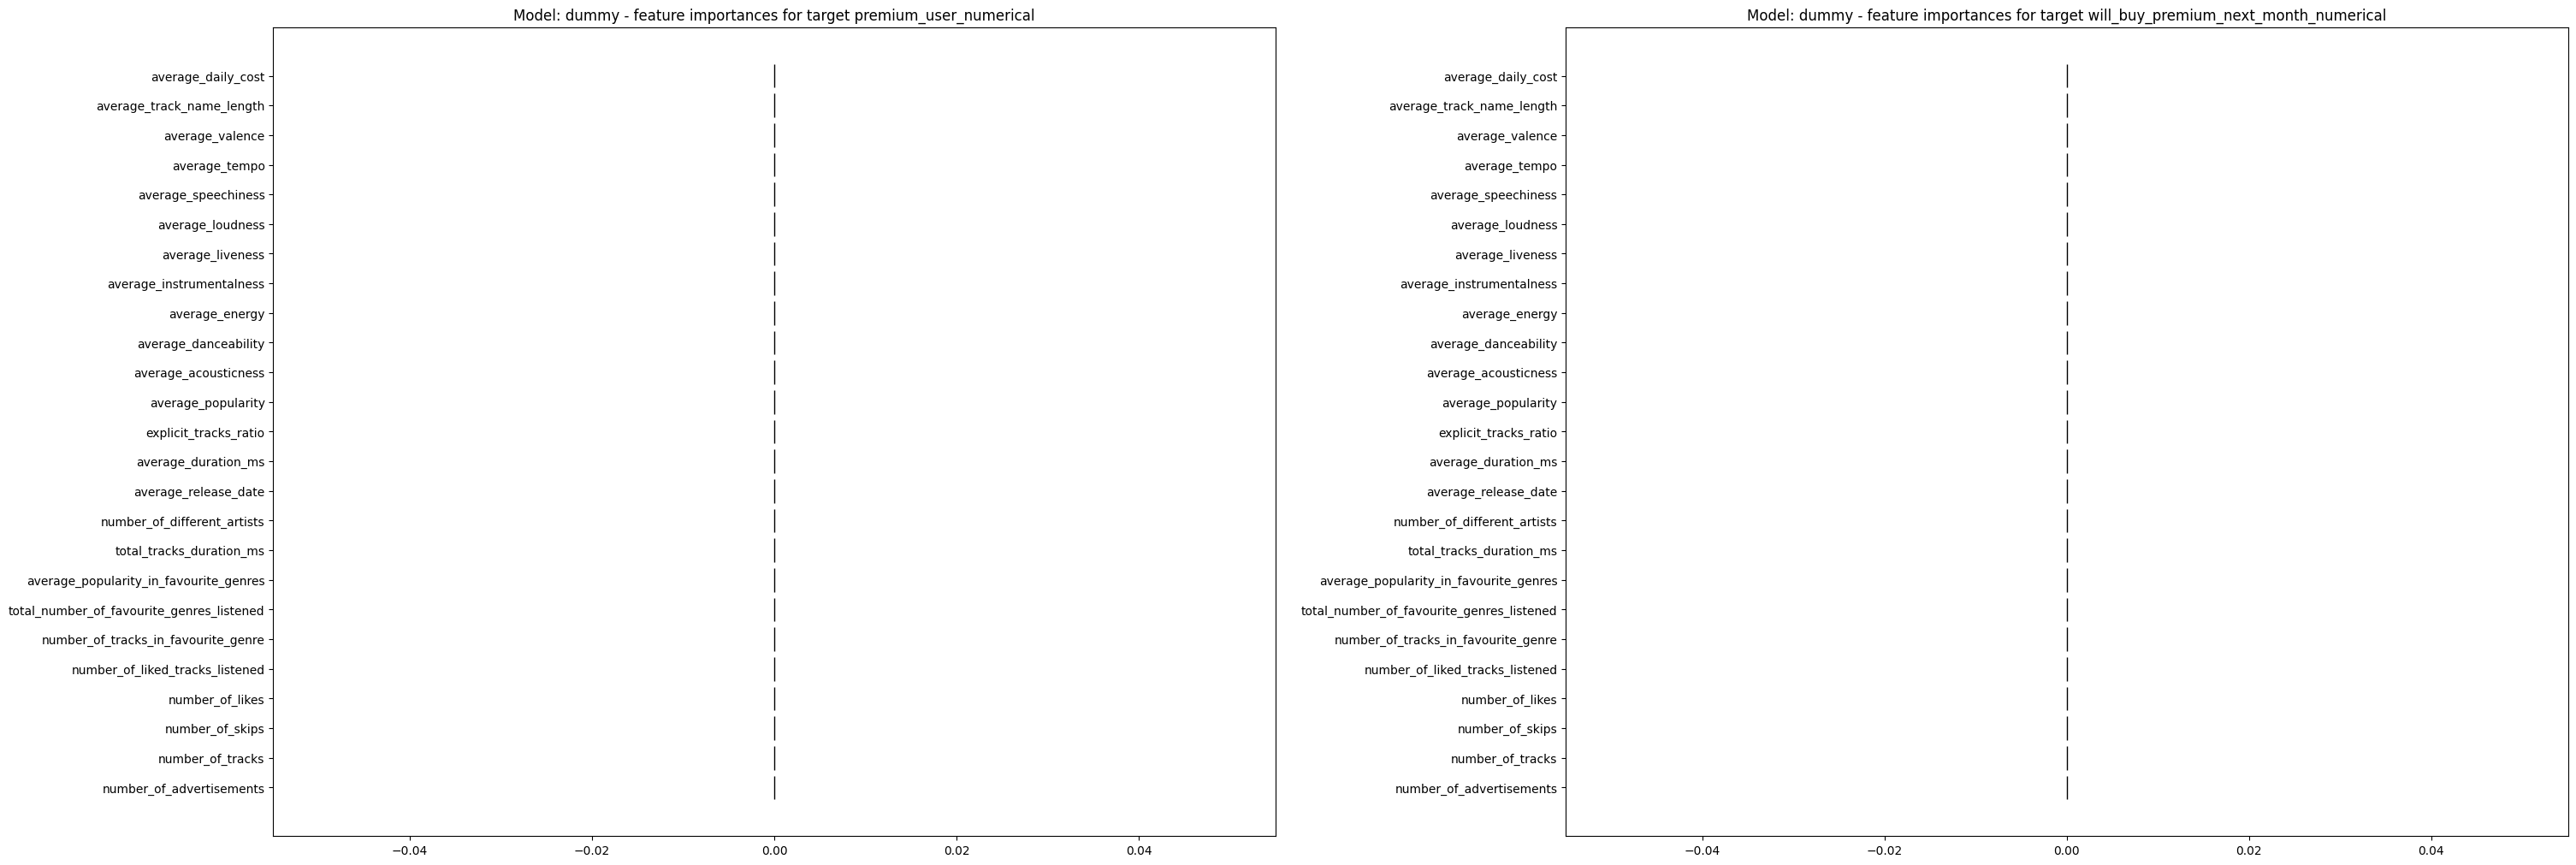

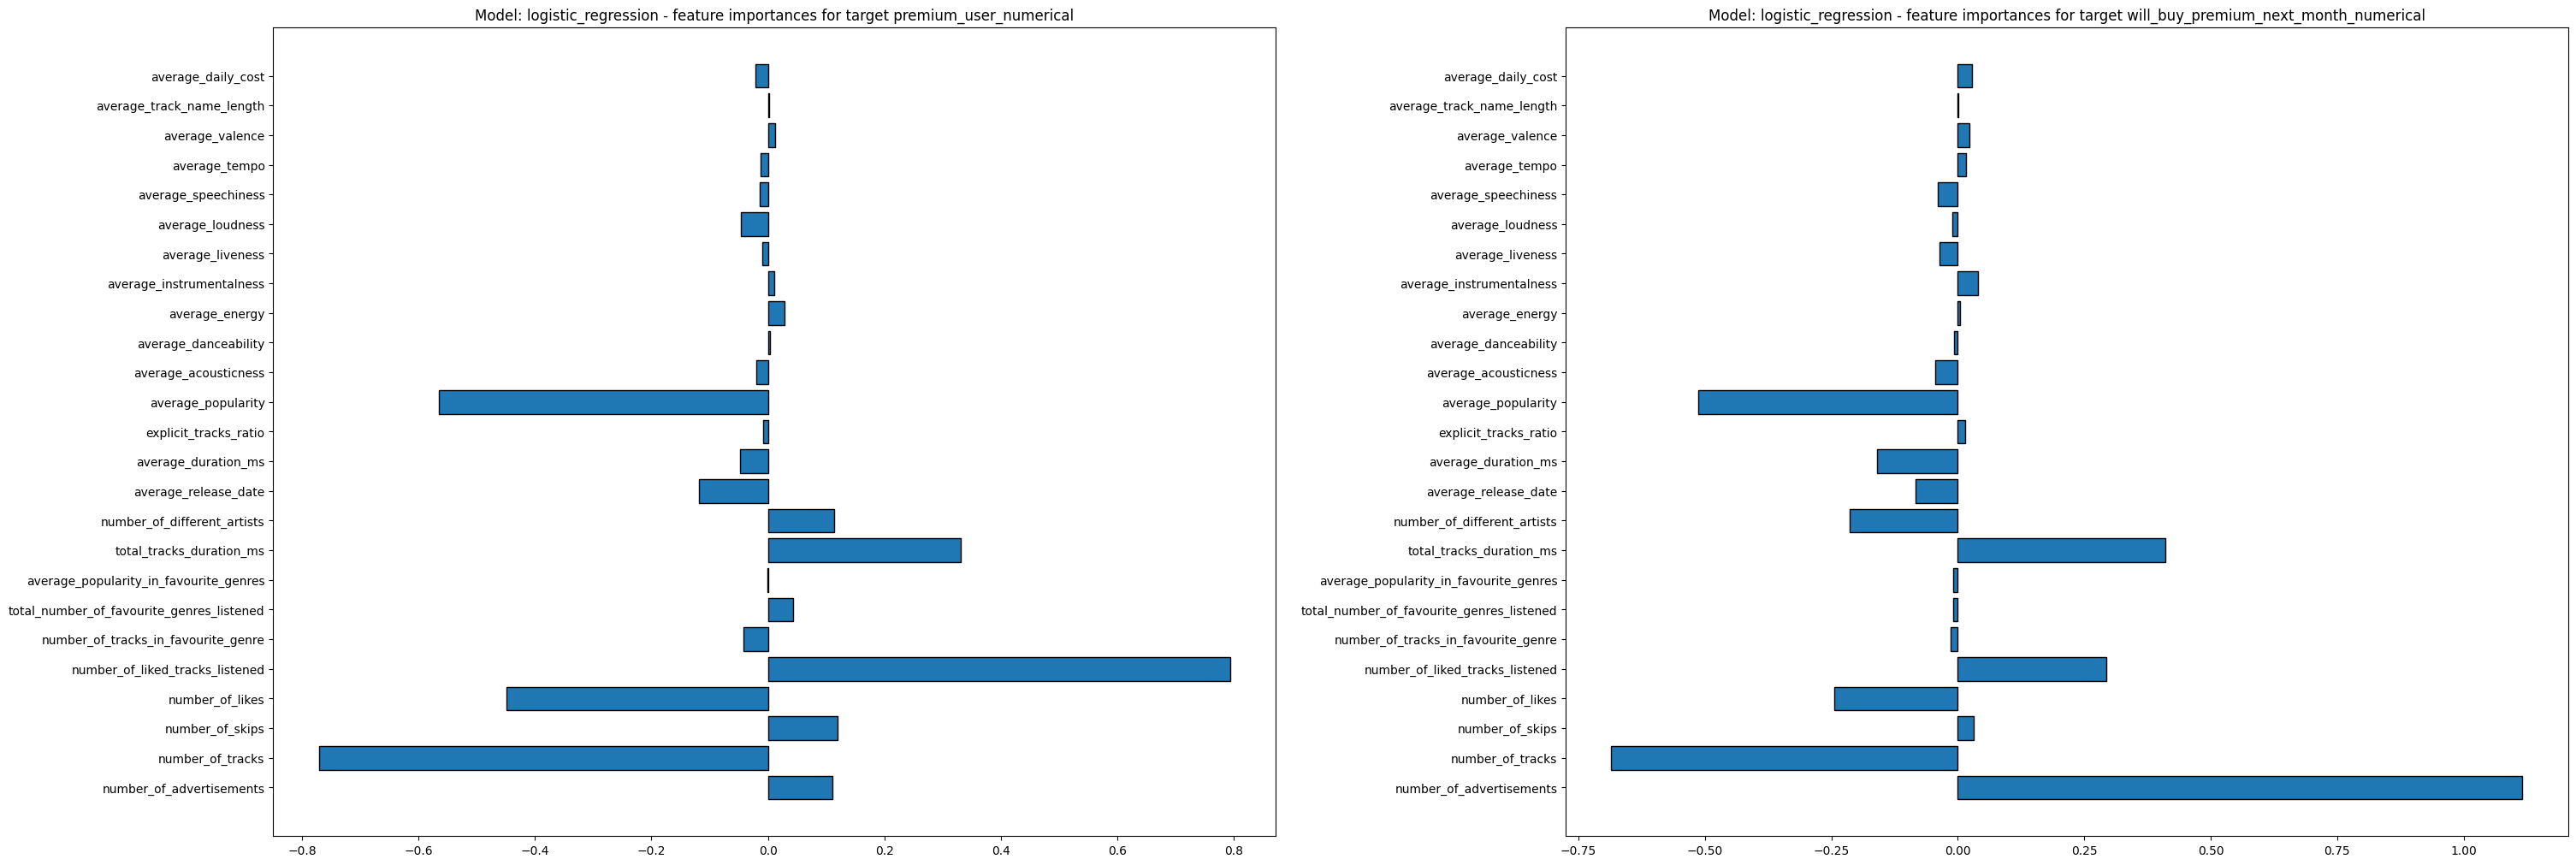

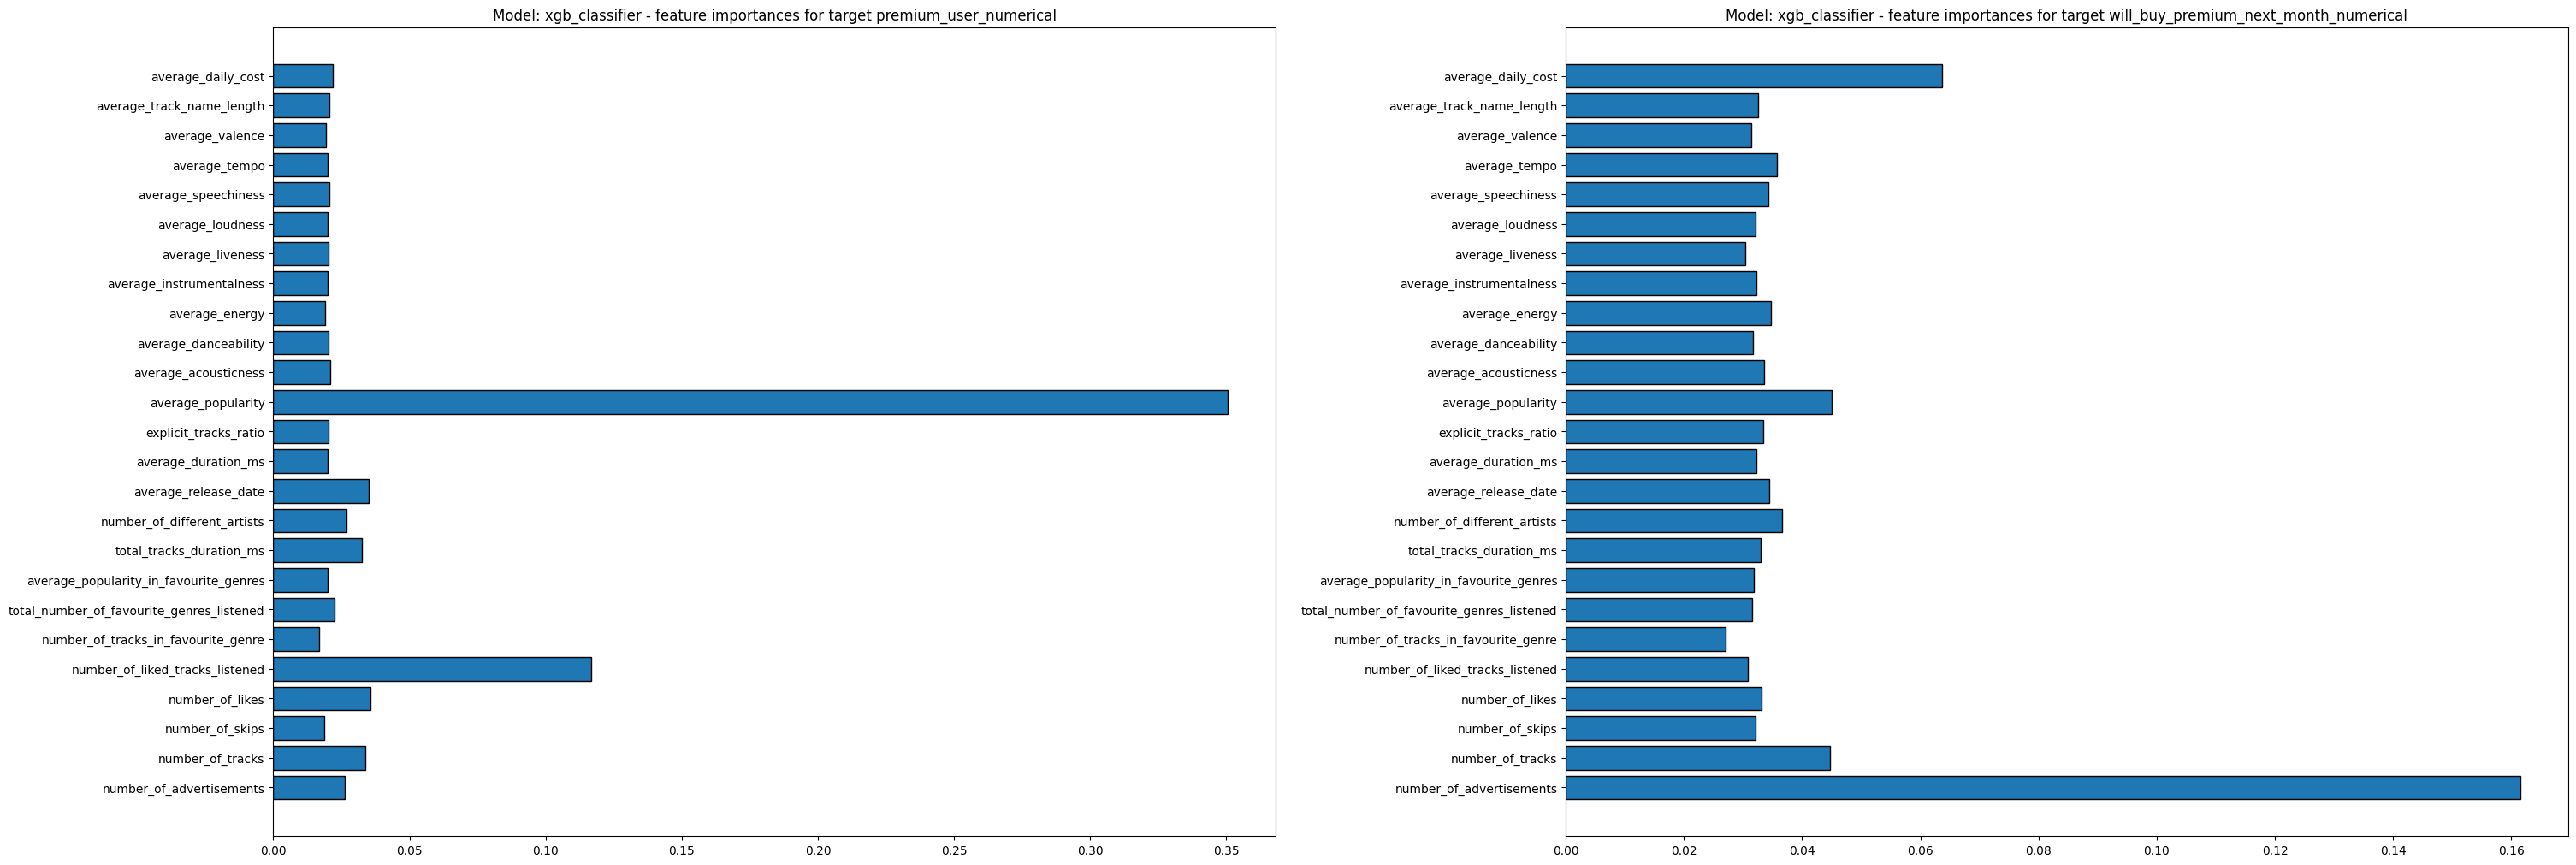

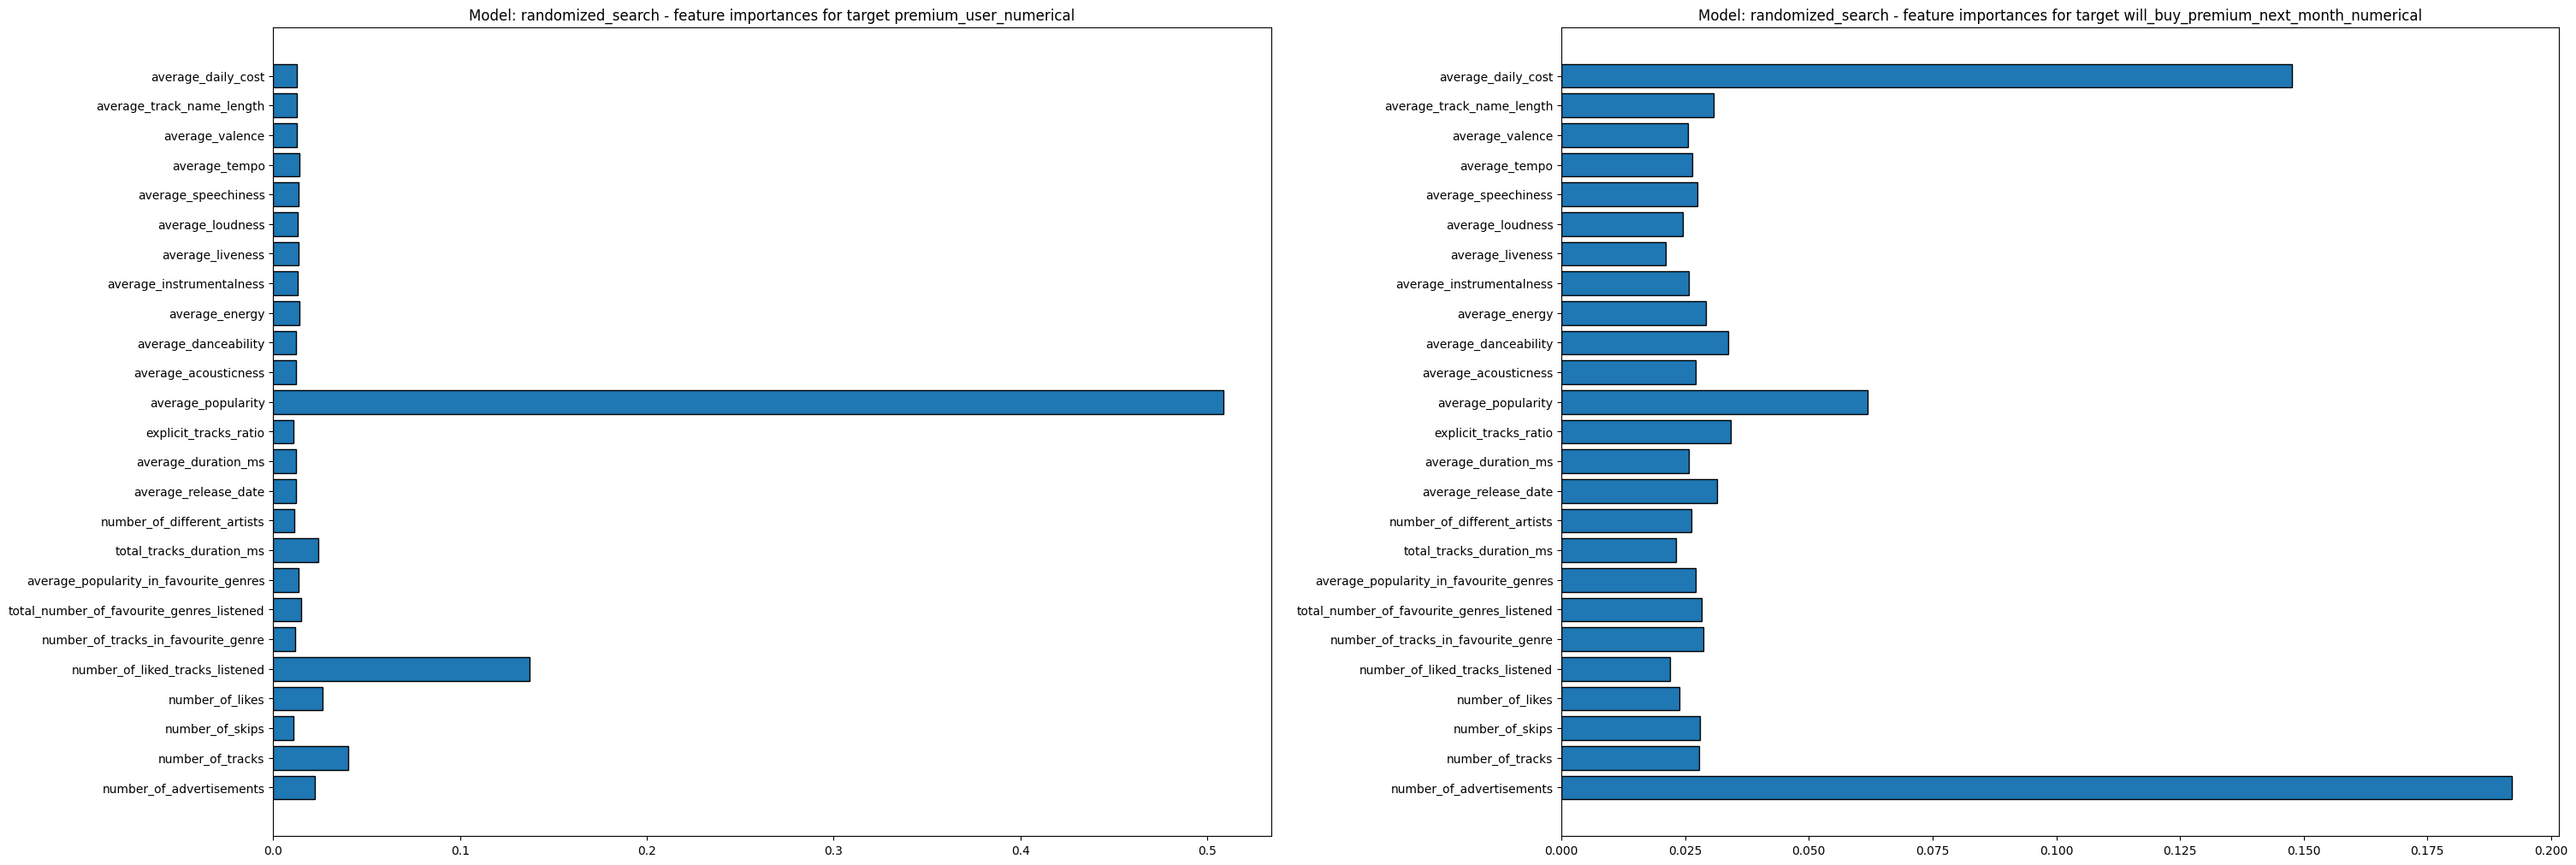

In [18]:
def retrieve_weights(model: Model) -> np.ndarray[np.float64]:
    if isinstance(model, LogisticRegression):
        return model.coef_[0]
    if isinstance(model, XGBClassifier):
        return model.feature_importances_
    return np.zeros(len(FEATURES))


for type in MODEL_TYPES:
    _, axs = plt.subplots(1, len(TARGETS), figsize=(
        30, 10), constrained_layout=True)
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        columns = FEATURES
        weights = retrieve_weights(model)
        axs[i].barh(y=columns, width=weights, edgecolor="black")
        axs[i].set_title(
            f"Model: {type} - feature importances for target {target}")
    plt.show()

In [ ]:
def get_class_weights(y: pd.Series, weights: List[float]) -> np.ndarray:
    return y.apply(lambda x: weights[x]).values


def train_score(
    model_class: Any,
    xgb_params: Dict[str, Any] = dict(),
) -> Tuple[List[float], Any, pd.DataFrame, pd.DataFrame]:
    _, axs = plt.subplots(2, 5, figsize=(40, 15))
    metrics = {
        "f1_score": [],
        "precision": [],
        "recall": [],
    }
    axs = axs.flatten()
    for month_ in np.arange(10) + 1:
        train_data = data_frame.loc[data_frame.month <= month_, :]
        test_data = data_frame.loc[data_frame.month == month_ + 1, :]
        X_train, y_train = train_data[FEATURES], train_data[TARGETS]
        X_test, y_test = test_data[FEATURES], test_data[TARGETS]
        X_train = pd.DataFrame(
            pipeline.fit_transform(X_train), columns=FEATURES)
        X_test = pd.DataFrame(pipeline.transform(X_test), columns=FEATURES)
        model = model_class(**xgb_params)
        model.fit(X_train, y_train)
        y_train_proba = model.predict_proba(X_train)
        thr = get_most_optimal_thr(y_train, y_train_proba)
        y_pred_proba = model.predict_proba(X_test)
        y_pred = get_preds_thr(y_pred_proba, thr)
        a = axs[month_ - 1]
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt="d", ax=a)
        a.set_title(f"{month_} test")
        metrics["f1_score"].append(f1_score(y_test, y_pred))
        metrics["precision"].append(precision_score(y_test, y_pred))
        metrics["recall"].append(recall_score(y_test, y_pred))
    return metrics, model, X_test, y_test

In [ ]:
def create_plot_from_model(x_train, y_train, x_test, y_test, subplots, model_constructor, model_params=dict()):
    data_train = pipeline.fit_transform(x_train)
    data_test = pipeline.transform(x_test)
    x_train = pd.DataFrame(data_train, columns=FEATURES)
    x_test = pd.DataFrame(data_test, columns=FEATURES)
    model = model_constructor(**model_params)
    model.fit(x_train, y_train)
    y_train_proba = model.predict_proba(x_train)
    # TODO: get_most_optimal_threshold
    thr = 0.2
    y_pred_proba = model.predict_proba(x_test)
    plots = []
    for i, target in enumerate(TARGETS):
        y_pred = pd.Series((y_pred_proba[:, i] > thr).astype(int))
        matrix_y_true = y_test[target]
        matrix_y_pred = y_pred
        f1_score_value = f1_score(matrix_y_true, matrix_y_pred)
        print(f"F1 score for {target}: {f1_score_value}")
        print(f"Precision: {precision_score(matrix_y_true, y_pred)}")
        print(f"Recall: {recall_score(matrix_y_true, y_pred)}")
        matrix = confusion_matrix(matrix_y_true, matrix_y_pred)
        sns.heatmap(
            matrix,
            annot=True,
            fmt='g',
            xticklabels=["0", "1"],
            yticklabels=["0", "1"],
            annot_kws={"fontsize": 40},
            ax=subplots[i]
        )
    return plots

In [ ]:
temp = 10
plots = []
MONTHS = 60
subplots = [plt.subplots(4, MONTHS//4, figsize=(100, 40))
            [1].flatten() for _ in TARGETS]
plot_statistics = []
for year, month in itertools.product(range(2019, 2023), range(1, 13)):
    temp += 1
    if temp % 10 != 0:
        continue
    data_train = data_frame.loc[
        data_frame.apply(lambda x: x.year < year or (
            x.month <= month and x.year == year), axis=1),
        :
    ]
    if len(data_train) == 0:
        continue
    data_test = data_frame.loc[
        data_frame.apply(lambda x: (x.month == month + 1 and x.year == year)
                         or (x.year == year + 1 and x.month == 1), axis=1),
        :
    ]
    x_train, y_train = data_train[FEATURES], data_train[TARGETS]
    x_test, y_test = data_test[FEATURES], data_test[TARGETS]

    plots.append(create_plot_from_model(x_train, y_train, x_test, y_test, [
                 subplot[temp] for subplot in subplots], XGBClassifier, randomized_search_cv.best_params_))

plt.show()

In [ ]:
# TODO: F1 score, Precision, Recall figures

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(30, 5))
axs = axs.flatten()
idx = 0
for names, values, m_name in zip(
    [logreg.feature_names_in_, xgb.feature_names_in_],
    [logreg.coef_[0], xgb.feature_importances_],
    ["LogisticRegression", "XGBClassifier"],
):
    a = axs[idx]
    a.barh(y=names, width=values, edgecolor="black")
    a.bar_label(a.containers[0], fmt="%.2f")
    a.set_title(f"{m_name} feature importances")
    idx += 1
plt.show()

In [ ]:
def train(
    model_class,
    model_name: str = "",
    xgb_params=dict(),
) -> None:
    X_train, y_train = TRAIN_DATA[FEATURES], TRAIN_DATA[TARGETS]
    X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=FEATURES)
    model = model_class(**xgb_params)
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)
    threshold = 0.2
    ium_model = IUMModel(pipeline, model, threshold)

    with open(f"models/{model_name}.pkl", "wb") as f:
        pkl.dump(ium_model, f)

In [ ]:
train(XGBClassifier, "xgbclassifier", randomized_search_cv.best_params_)
# train(LogisticRegression, "logistic_regression")

In [ ]:
data_frame = pd.read_csv(FEATURE_PATH)

data_frame = data_frame.loc[data_frame.month == 11, :]

randomized_indices = np.random.permutation(data_frame.index)
A = data_frame.loc[randomized_indices[:int(0.5*len(data_frame))]]
B = data_frame.loc[randomized_indices[int(0.5*len(data_frame)):]]

In [ ]:
def perform_test(model, data):
    # Initiate empty DataFrame
    export = {"user_id": [], "guess": [], "ground_truth": [], "model": []}
    export = pd.DataFrame(export)
    # Go over all records
    for i in range(0, len(data)):
        # Extract one record
        row_vals = data.iloc[i]
        # Save the users id and the ground truth for future use
        user_id = row_vals.user_id
        ground_truth = row_vals.is_premium
        # Delete user id, month and is premium columns as they are unnecessary
        row_vals.drop('user_id')
        row_vals.drop('month')
        row_vals.drop('is_premium')
        # Extract only the values
        row_vals = row_vals.values
        # Prepare the request
        features = ','.join(map(str, row_vals))
        request = "http://127.0.0.1:8000/models/" + model + "?features=" + features
        # Get prediction from microservice
        guess = requests.get(request).json()
        # Append prediction to DataFrame
        line = pd.DataFrame({"user_id": [user_id], "guess": [
                            guess["prediction"]], "ground_truth": [ground_truth], "model": [model]})
        export = pd.concat([export, line], ignore_index=True)
    return export

In [ ]:
xgb = perform_test("xgbclassifier", A)
logic = perform_test("logistic_regression", B)

In [ ]:
xgb.guess.value_counts()

In [ ]:
xgb.ground_truth.value_counts()

In [ ]:
logic.guess.value_counts()

In [ ]:
logic.ground_truth.value_counts()

In [ ]:
xgb.to_csv(os.path.join("results", "xgb.csv"), index=None)
logic.to_csv(os.path.join("results", "logic.csv"), index=None)

In [ ]:
print("f1", f1_score(xgb.ground_truth, xgb.guess))
print("f1", f1_score(logic.ground_truth, logic.guess))

In [ ]:
np.random.seed(1234)

print(f"{BUCKETS_CNT=}, {T_ALPHA=}")
data = load_data()
buckets_indices = get_buckets_indices(data.user_id.values)
xgb_f1_score, logreg_f1_score = get_xgb_logreg_f1_scores(data, buckets_indices)
print(f"{np.mean(xgb_f1_score)=}, {np.mean(logreg_f1_score)=}")
s_p = get_s_p(xgb_f1_score, logreg_f1_score)
t = get_t(xgb_f1_score, logreg_f1_score, s_p)
print(f"{s_p=}, {t=}")
if is_xgb_better(t):
    print("XGBClassifier is better than LogisticRegression")
else:
    print("We can't say that XGBClassifier is better than LogisticRegression")